In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data

In [2]:
def unflatten_image(image_list):
    new_list = []
    for image in image_list:
        new_list.append(image.reshape(32,32))

    return np.array(new_list)

In [3]:
def load_pickle(path):
    with open(path, 'rb') as fo:
        data = pickle.load(fo)

    data = unflatten_image(data)
    return data

In [4]:
face = load_pickle('../data/faces_python.pkl')
non_face = load_pickle('../data/nonfaces_python.pkl')
face_label = np.ones(face.shape[0])
non_face_label = np.zeros(non_face.shape[0])

In [5]:
train_test_ratio = 0.2

tmp1 = np.round(face.shape[0]*train_test_ratio).astype(int)
train_face_label = face_label[:tmp1]
test_face_label = face_label[tmp1:]
train_face = face[:tmp1,:,:]
test_face = face[tmp1:,:,:]

tmp2 = np.round(face.shape[0]*train_test_ratio).astype(int)
train_non_face_label = non_face_label[:tmp2]
test_non_face_label = non_face_label[tmp2:]
train_non_face = non_face[:tmp2,:,:]
test_non_face = non_face[tmp2:face.shape[0],:]

train_image = np.concatenate((train_face, train_non_face), axis=0)
train_label = np.concatenate((train_face_label, train_non_face_label), axis=0)

test_image = np.concatenate((test_face, test_non_face), axis=0)
test_label = np.concatenate((test_face_label, test_non_face_label), axis=0)

In [6]:
class FaceDataset(data.Dataset):
    def __init__(self, image_list, label_list):
        self.images = image_list
        self.labels = label_list

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]


        return img, label

In [7]:
train_dataset = FaceDataset(train_image, train_label)
test_dataset = FaceDataset(test_image, test_image)

In [8]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

dataloaders_dict = {"train":train_dataloader, "val":test_dataloader}

In [9]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([128, 32, 32])
tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 1.], dtype=torch.float64)


In [10]:
# defines a small CNN based on the nn.Module class
class CNN(nn.Module):
    # every nn needs the constructor
    def __init__(self):
        # call the pytorch constructor of the parent class
        super().__init__()
        # first convolutional layer
        # 3 input layers [because of color images]
        # 16 filters with 5x5 pixels each
        self.conv1 = nn.Conv2d(3, 16, 5)
        # pool using 2x2 grid [downsampling]
        self.pool = nn.MaxPool2d(2, 2)
        # second convolutional layer
        # 16 input layers [because of first conv layer]
        # 32 filters with 5x5 pixels each
        self.conv2 = nn.Conv2d(16, 32, 5)
        # fully connected layer [the 32*5*5 needs to calculated]
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    # every nn needs a forward pass function which takes data x
    # as input and returns x as output
    # the forward function uses the layers defined in the 
    # constructor to make the network architecture
    def forward(self, x):
        # Relu of first CONV and pool
        x = self.pool(F.relu(self.conv1(x)))
        # Relu of second CONV and pool
        x = self.pool(F.relu(self.conv2(x)))
        # flatten output so that it fits into fc layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x


net = CNN()

In [11]:
# define the loss - typically, classification is trained with
# the cross entropy loss
criterion = nn.CrossEntropyLoss()
# define the optimizer that will train the network for us
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
net.to(device)

# visualize the architecture
import hiddenlayer as hl

hl.build_graph(net, torch.zeros([1, 3, 32, 32]).to(device))

ModuleNotFoundError: No module named 'hiddenlayer'

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    # load a batch of data
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + loss + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.300
[1,   200] loss: 2.266
[1,   300] loss: 2.200
[1,   400] loss: 2.155
[1,   500] loss: 2.079
[1,   600] loss: 2.082
[1,   700] loss: 1.975
[1,   800] loss: 1.879
[1,   900] loss: 1.872
[1,  1000] loss: 1.811
[1,  1100] loss: 1.788
[1,  1200] loss: 1.704
[1,  1300] loss: 1.700
[1,  1400] loss: 1.682
[1,  1500] loss: 1.688
[1,  1600] loss: 1.614
[1,  1700] loss: 1.637
[1,  1800] loss: 1.636
[1,  1900] loss: 1.612
[1,  2000] loss: 1.584
[1,  2100] loss: 1.545
[1,  2200] loss: 1.548
[1,  2300] loss: 1.565
[1,  2400] loss: 1.548
[1,  2500] loss: 1.534
[1,  2600] loss: 1.551
[1,  2700] loss: 1.588
[1,  2800] loss: 1.577
[1,  2900] loss: 1.573
[1,  3000] loss: 1.501
[1,  3100] loss: 1.549
[1,  3200] loss: 1.511
[1,  3300] loss: 1.494
[1,  3400] loss: 1.450
[1,  3500] loss: 1.515
[1,  3600] loss: 1.511
[1,  3700] loss: 1.505
[1,  3800] loss: 1.404
[1,  3900] loss: 1.440
[1,  4000] loss: 1.427
[1,  4100] loss: 1.427
[1,  4200] loss: 1.460
[1,  4300] loss: 1.345
[1,  4400] 

[6,  4800] loss: 0.875
[6,  4900] loss: 0.921
[6,  5000] loss: 0.900
[6,  5100] loss: 0.906
[6,  5200] loss: 0.876
[6,  5300] loss: 0.954
[6,  5400] loss: 0.819
[6,  5500] loss: 0.963
[6,  5600] loss: 0.919
[6,  5700] loss: 0.905
[6,  5800] loss: 0.934
[6,  5900] loss: 0.840
[6,  6000] loss: 0.873
[6,  6100] loss: 0.912
[6,  6200] loss: 0.931
[7,   100] loss: 0.845
[7,   200] loss: 0.857
[7,   300] loss: 0.881
[7,   400] loss: 0.815
[7,   500] loss: 0.917
[7,   600] loss: 0.880
[7,   700] loss: 0.920
[7,   800] loss: 0.865
[7,   900] loss: 0.875
[7,  1000] loss: 0.877
[7,  1100] loss: 0.886
[7,  1200] loss: 0.817
[7,  1300] loss: 0.909
[7,  1400] loss: 0.883
[7,  1500] loss: 0.859
[7,  1600] loss: 0.849
[7,  1700] loss: 0.817
[7,  1800] loss: 0.958
[7,  1900] loss: 0.888
[7,  2000] loss: 0.820
[7,  2100] loss: 0.875
[7,  2200] loss: 0.851
[7,  2300] loss: 0.891
[7,  2400] loss: 0.854
[7,  2500] loss: 0.864
[7,  2600] loss: 0.887
[7,  2700] loss: 0.885
[7,  2800] loss: 0.888
[7,  2900] 

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# this will hold all activations for all classes for 
# later plotting of confusion matrix
full_pred = np.empty((len(testloader)*batch_size,len(classes)))
# again no gradients needed
with torch.no_grad():
    # go through all elements in the test set
    for i,data in enumerate(testloader):
        # again push them to device
        inputs, labels = data[0].to(device), data[1].to(device)
        # we need the forward pass
        outputs = net(inputs)
        # and store for later use
        full_pred[i*batch_size:i*batch_size+batch_size,:]=outputs.cpu().numpy()
        
        # the predicted class is the maximum across the
        # batch for the second dimension
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 67.5 %
Accuracy for class car   is: 73.3 %
Accuracy for class bird  is: 42.5 %
Accuracy for class cat   is: 36.4 %
Accuracy for class deer  is: 31.3 %
Accuracy for class dog   is: 70.2 %
Accuracy for class frog  is: 61.0 %
Accuracy for class horse is: 55.3 %
Accuracy for class ship  is: 69.3 %
Accuracy for class truck is: 56.9 %


In [ ]:
import itertools
# function to plot confusion matrix
# adapted from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = '{} Accuracy: {:.2f}'.format(
            title,np.mean(np.diag(cm)))
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=26)
    cbar = plt.colorbar()
    # this is needed to adjust the small ticklabels on the colorbar
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(20)
    # show the x and y ticks with nice rotation if needed
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=22)
    plt.yticks(tick_marks, classes,fontsize=22)

    fmt = '.2f' if normalize else 'd'
    # adjust threshold for black / white font
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=22
                )

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label',fontsize=22)

Normalized confusion matrix


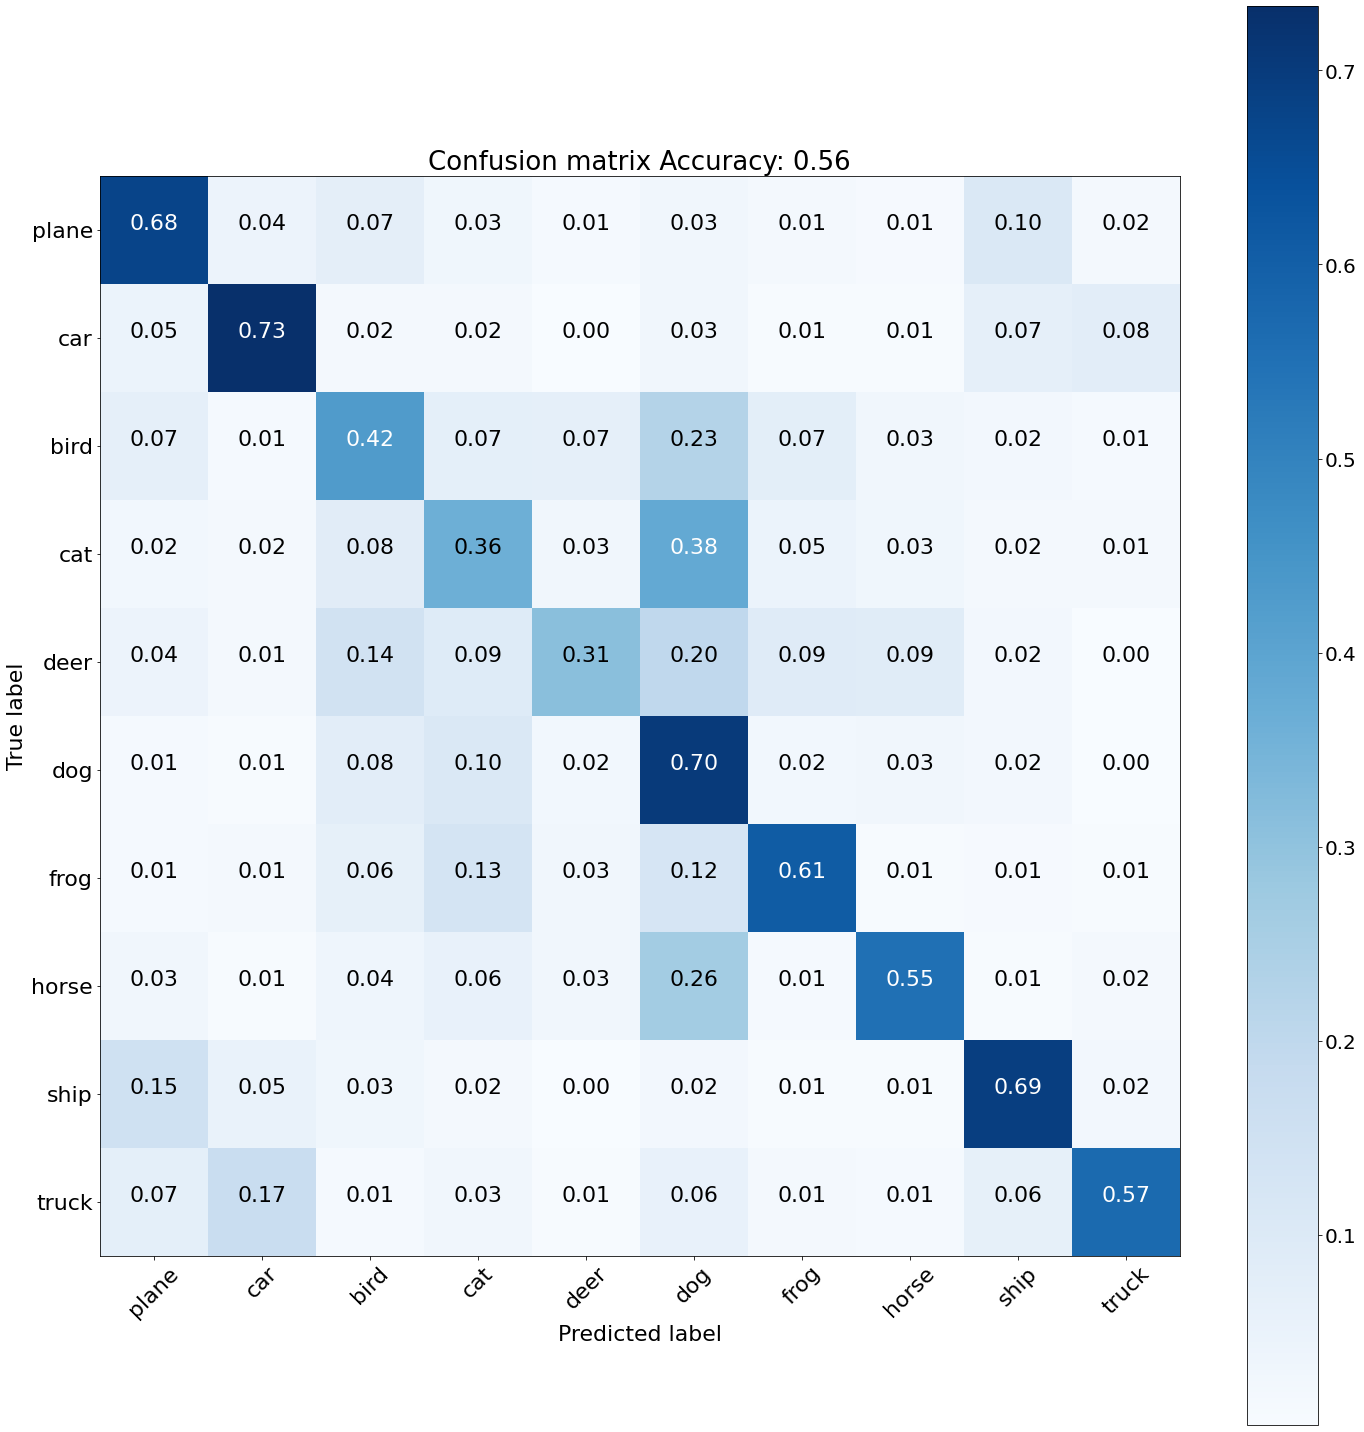

In [ ]:
# make confusion matrix
cm = np.zeros((len(classes),len(classes)))
# the true labels
tr = testset.targets
# the predicted labels
pr = full_pred.argmax(axis=1)
# add for each pair
for i in range(len(testset.targets)):
    cm[tr[i],pr[i]]+=1
    
plot_confusion_matrix(cm,classes,normalize=True)